# Batch Normalization

딥러닝 모델에서 이전의 레이어의 파라미터가 변하면서, 각 레이어의 입력 분포가 변하기 때문에 모델 학습이 매우 어려움.  

이런 현상을 Internal Covariate Shift(ICS) 라고 하는데 저자들은 배치 정규화가 ICS를 줄이면서 학습 능력을 향상시킨다고 주장

배치 정규화 장점
1. 학습 속도 가속화
2. 가중치 초기화 부담 감소
3. 모델의 일반화 능력 향상

이전 연구
1. 입력 정규화 : 각 축의 데이터가 비슷한 값의 범위를 갖는 것이 목표  
ex) 0 ~ 255 > 0 ~ 1 or -1 ~ 1로 정규화 등   
2. 입력 표준화 : 각 축에 대하여 표준정규분포값을 갖는 것이 목표

이런 입력 데이터의 정규화를 레이어 마다 하면 학습이 잘 되지 않을까?

## Internal covariate shift

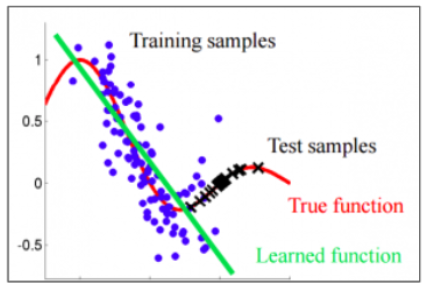

Covariate shift : training set과 test set의 분포가 달라서 발생하는 문제로 다른 분포를 학습하여 제대로 성능을 내지 못하게 된다.  

ICS 는 covariate shift가 신경망에서 각 레이어들 사이에서도 발생하는 것으로 이전 레이어의 파라미터 변화로 각 레이어의 입력 데이터의 분포가 변화되는 현상.  



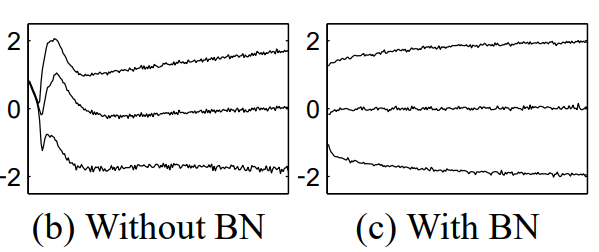

BN의 사용 유무에 따른 입력데이터의 분포 변화

### Whitening

위의 현상을 막기 위해 각 레이어의 입력을 정규화 시키는 방법으로 whitening이 있다.  
whitening 은 입력 데이터의 각 feature에 대해서 평균을 0 분산을 1로 하며 feature 들을 uncorrelated하게 만들어준다.

허나 계산량이 많고 일부 파라미터의 영향이 무시될 수 있어 학습을 악화 시킬 수 있다고 논문에서 확인함


## Batch normalization algorithm

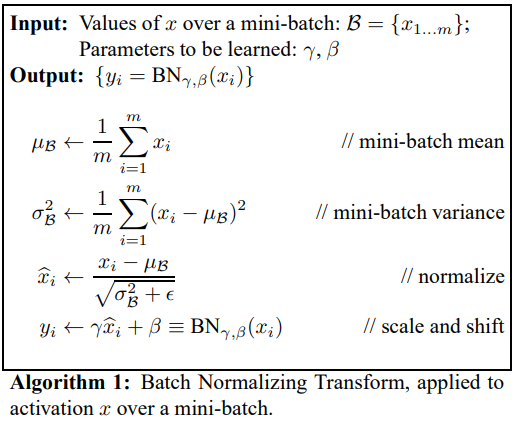

미니 배치 상에서 데이터들의 평균과 분산을 구해서 정규화  

이때 $𝛆$ 은 연산의 안정성을 위한 작은 양수  

정규화된 데이터에 $\gamma,β$를 이용하여 scale, shift

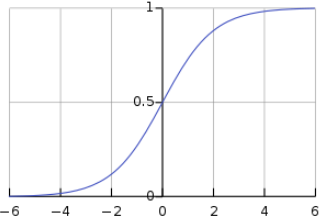

시그모이드 같은 경우 선형적인 구간이 있어서 만약 N(0,1)로 정규화를 하면  
비선형 활성화 함수의 영향력이 감소할 수 있으므로 $\gamma,β$를 이용

### How does batch normalization help opimization?
https://arxiv.org/pdf/1805.11604.pdf  

배치 정규화로 인해 모델 학습/성능이 향상 되는것은 ICS와 관계가 없음. 

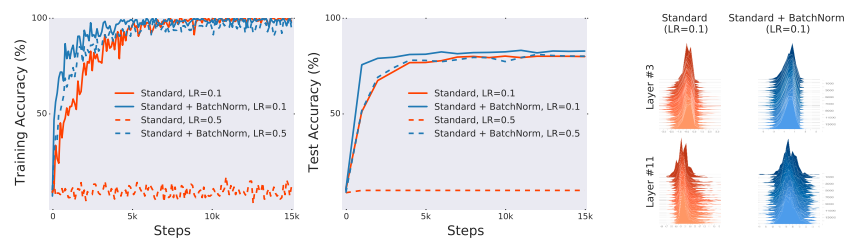

BN을 이용할시 성능은 좋아지지만 스텝 수가 증가하면서 활성화된 값들의 분포는 BN을 사용하지 않은 모델과 큰 차이가 보이지 않는다.

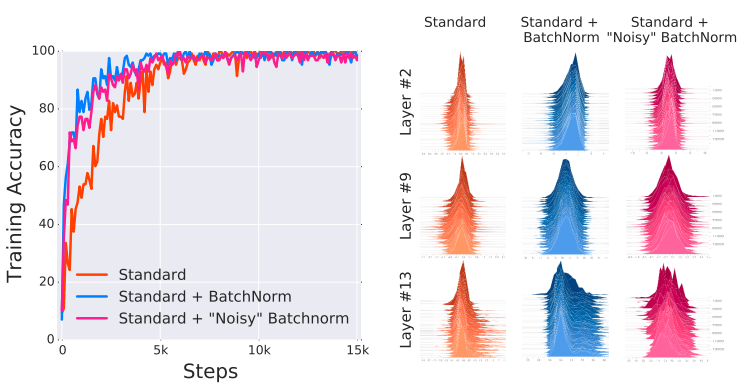

심지어 노이즈를 추가하여 입력데이터의 분포가 급격하게 변해도 오히려 더 좋은 성능을 내는 것을 확인하면서 성능과 ICS간에는 관계가 없는 것으로 보임  

BN이 효과를 보이는 이유는 solution space를 더욱 smooth 하게 하여 높은 학습률에서도 안정적으로 학습할 수 있게 해준다



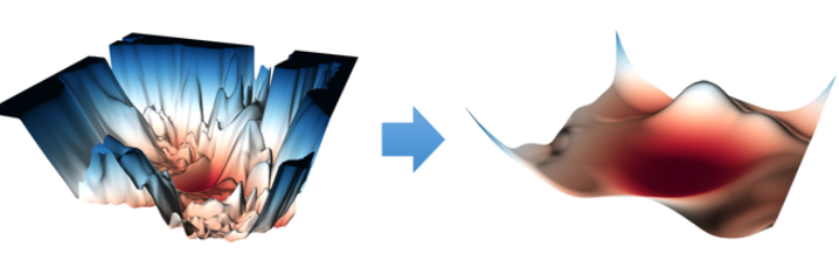

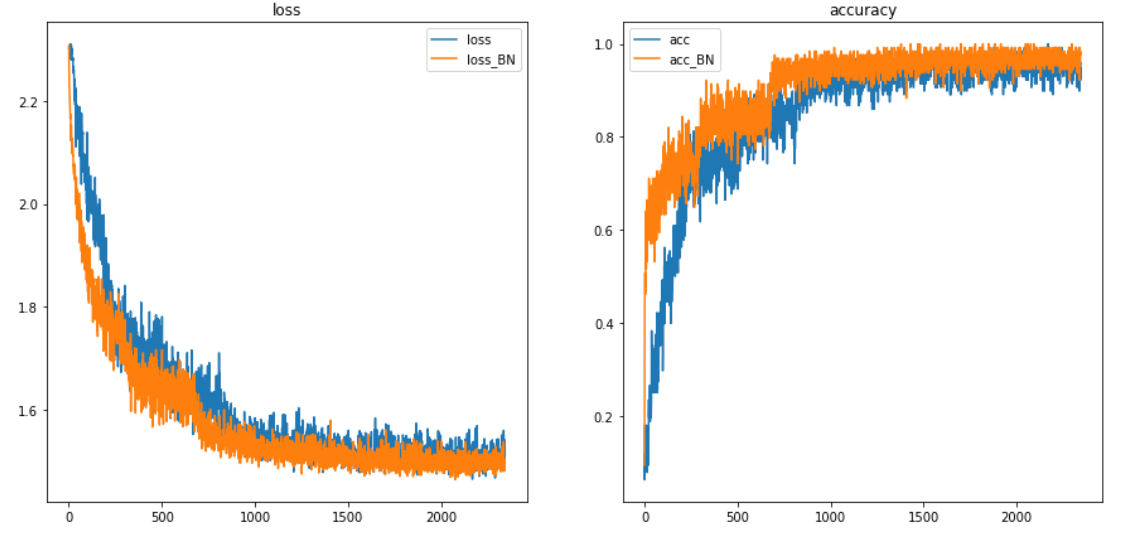

# 코드 실습

In [1]:
# https://wikidocs.net/61271
# https://arxiv.org/pdf/1502.03167.pdf
# https://eehoeskrap.tistory.com/430

In [2]:
# 라이브러리

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 데이터 불러오기

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train = True,
                               download = True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                         shuffle = True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [6]:
# 모델 정의

class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.m = nn.Sequential(
        nn.Linear(784, 512),
        nn.Sigmoid(),

        nn.Linear(512, 256),
        nn.Sigmoid(),

        nn.Linear(256, 128),
        nn.Sigmoid(),

        nn.Linear(128, 10),
        nn.Softmax()
    )
  
  def forward(self, x):
    x = x.view(-1, 28*28*1)
    out = self.m(x)
    return out


class model_BN(nn.Module):
  def __init__(self):
    super(model_BN, self).__init__()
    self.m = nn.Sequential(
        nn.Linear(784, 512),
        nn.BatchNorm1d(512),
        nn.Sigmoid(),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Sigmoid(),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Sigmoid(),

        nn.Linear(128, 10),
        nn.Softmax()
    )
  
  def forward(self, x):
    x = x.view(-1, 28*28*1)
    out = self.m(x)
    return out

In [7]:
# 학습 준비

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

modelBN = model_BN().to(device)
criterionBN = nn.CrossEntropyLoss()
optimizerBN = torch.optim.SGD(modelBN.parameters(),lr = 0.001)
#optimizerBN = torch.optim.Adam(modelBN.parameters(), lr = 0.001)

In [ ]:
n_epochs = 200

loss_list = []
acc_list = []

lossBN_list = []
accBN_list = []

for epoch in range(n_epochs):

  for i, (data,label) in enumerate(dataloader):
    data = data.to(device)
    labels = F.one_hot(label, 10)
    labels = torch.tensor(labels, dtype=torch.float, device=device)

    optimizer.zero_grad()
    optimizerBN.zero_grad()

    outs = model(data)
    outsBN = modelBN(data)

    loss = criterion(outs, labels)
    lossBN = criterionBN(outsBN, labels)

    loss.backward()
    lossBN.backward()

    optimizer.step()
    optimizerBN.step()

    # save loss
    loss_list.append(loss.item())
    lossBN_list.append(lossBN.item())

    # save accuracy
    pred = np.argmax(outs.cpu().detach().numpy(), axis=1)
    acc = np.sum(pred==label.cpu().detach().numpy())/label.size(0)
    acc_list.append(acc)
    predBN = np.argmax(outsBN.cpu().detach().numpy(), axis=1)
    accBN = np.sum(predBN==label.cpu().detach().numpy())/label.size(0)
    accBN_list.append(accBN)
  print('[%d/%d] is done !'%(epoch, n_epochs))

Text(0.5, 1.0, 'accuracy')

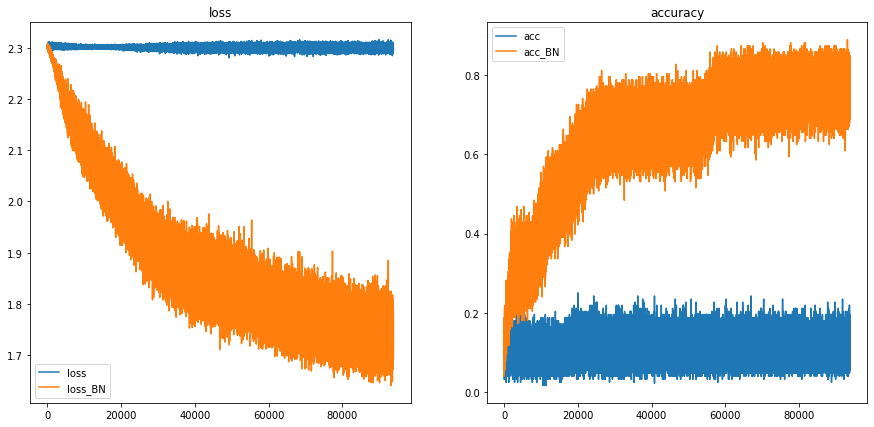

In [10]:
# 비교하기 SGD

fig, axes = plt.subplots(1,2, figsize=(15,7))
axes[0].plot(loss_list, label='loss')
axes[0].plot(lossBN_list, label='loss_BN')
axes[0].legend()
axes[0].set_title('loss')

axes[1].plot(acc_list, label='acc')
axes[1].plot(accBN_list, label='acc_BN')
axes[1].legend()
axes[1].set_title('accuracy')

Text(0.5, 1.0, 'accuracy')

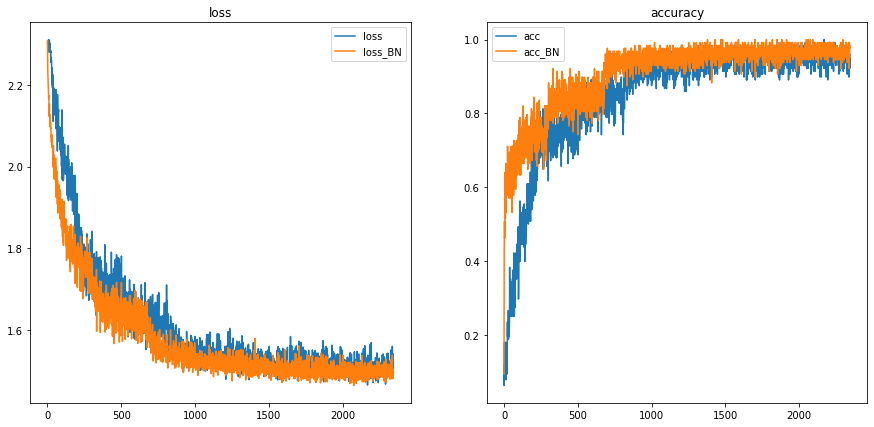

In [ ]:
# 비교하기 Adam

fig, axes = plt.subplots(1,2, figsize=(15,7))
axes[0].plot(loss_list, label='loss')
axes[0].plot(lossBN_list, label='loss_BN')
axes[0].legend()
axes[0].set_title('loss')

axes[1].plot(acc_list, label='acc')
axes[1].plot(accBN_list, label='acc_BN')
axes[1].legend()
axes[1].set_title('accuracy')